<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: Лисицын Сергей
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 9. Разреженные данные, онлайн-обучение</center>

## <center>Часть 2. Vowpal Wabbit</center>

Vowpal Wabbit (VW) является одной из наиболее широкоиспользуемых библиотек в индустрии. Её отличает высокая скорость работы и поддержка большого количества различных режимов обучения. Особый интерес для больших и высокоразмерных данных представляет онлайн-обучение - самая сильная сторона библиотеки. 


Основным интерфейсом для работы с VW является shell

In [1]:
import sklearn.datasets
import sklearn.model_selection
import sklearn.metrics
import re

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

Для того, чтобы изучить возможные режимы работы vw воспользуемся командой ! для запуска:

In [2]:
!vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all 

Vowpal Wabbit считывает данные из файла или стандартного ввода (stdin) в формате, который имеет следующий вид:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

где [] обозначает необязательные элементы, а (...)\* означает повтор неопределенное число раз. 

- **Label** является числом, "правильным" ответом. В случае классификации обычно принимает значение 1/-1, а в случае регрессии некоторое вещественное число
- **Importance** является числом и отвечает за вес примера при обучении. Это позволяет бороться с проблемой несбалансированных данных, изученной нами ранее
- **Tag** является некоторой строкой без пробелов и отвечает за некоторое "название" примера, которое сохраняется при предсказании ответа. Для того, чтобы отделить Tag от Importance лучше начинать Tag с символа '.
- **Namespace** служит для создания отдельных пространств признаков. В аргументах Namespace именуются по первой букве, это нужно учитывать при выборе их названий
- **Features** являются непосредственно признаками объекта внутри **Namespace**. Признаки по умолчанию имеют вес 1.0, но его можно переопределить, к примеру feature:0.1. 


К примеру, под такой формат подходит следующая строка:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


чтобы убедиться в этом, запустим vw с этим обучающим примером:

In [3]:
! echo '1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park' | vw

For more information use: vw --help
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000            1         1.0   1.0000   0.0000       10

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1
weighted label sum = 1
average loss = 1
best constant = 1
total feature number = 10


VW является прекрасным инструментом для работы с текстовыми данными. Убедимся в этом с помощью выборки 20newsgroups, содержащей письма из 20 различных тематических рассылок:

In [4]:
newsgroups = sklearn.datasets.fetch_20newsgroups('../../data/')

Рассмотрим первый текстовый документ этой коллекции:

In [5]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Выполним простейшую обработку текста: избавимся от регистра и найдем все слова длиннее трех символов:

In [14]:
def vowpalize(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

vowpalize(text, 1 if target == 'rec.autos' else -1)

'-1 |text from eric choi f175 n2240 fidonet org eric choi subject mac portable powerbook 100 answers organization fidonet node 2240 175 association mac bbs grand blanc lines can the internal hard drive the macportable upgraded larger capacity what the specs drive lps model there any third party modem greater than 2400 bps with fax option notice the macportable batteries are avalable thru the apple catalog eric choi internet eric choi f175 n2240 fidonet org\n'

Разобьем выборку на обучающую и тестовую и запишем в файл преобразованные таким образом документы. Будем считать документ положительным, если он относится к рассылке 'rec.autos'. Так мы построим модель, отличающую письма про автомобили от остальных: 

In [15]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' else -1 for target in newsgroups['target']]

train_documents, test_documents, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(all_documents, all_targets)
    
with open('../../output/20news_train.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(vowpalize(text, target))
with open('../../output/20news_test.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(vowpalize(text))

Запустим vw на сформированном файле. Мы решаем задачу классификации, поэтому зададим функцию потерь в значение hinge. В следующей части занятия мы изучим поддерживаемые vw функции потерь. Построенную модель мы сохраним в соответствующий файл 20news_model.vw:

In [16]:
!vw -d ../../output/20news_train.vw --loss_function hinge -f ../../output/20news_model.vw

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
final_regressor = ../../output/20news_model.vw
using no cache
Reading datafile = ../../output/20news_train.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000            1         1.0  -1.0000   0.0000      118
0.561598   0.123197            2         2.0  -1.0000  -0.8768      308
0.642714   0.723830            4         4.0  -1.0000  -0.1362       35
0.432619   0.222524            8         8.0  -1.0000  -1.0000      234
0.324255   0.215891           16        16.0  -1.0000  -0.9577      129
0.359620   0.394986           32        32.0  -1.0000  -0.8468      107
0.226038   0.092455           64        64.0  -1.0000  -0.9744       98
0.240802   0.255566          128       128.0  -1.0000  -0.6582       82
0.208579   0.176357          256       256.0  -1.0000  -0.3968       95
0.181998   0.

Модель обучена. VW выводит достаточно много полезной информации по ходу обучения. Обратите внимание, что average loss снижался по ходу выполнения итераций. Для вычисления функции потерь VW использует еще не просмотренные примеры, поэтому как правило эта оценка является корректной. Применим обученную модель на тестовой выборке, сохраняя предсказания в файл с помощью опции -p: 

In [17]:
!vw -i ../../output/20news_model.vw -t -d ../../output/20news_test.vw -p ../../output/20news_test_predictions.txt

only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = ../../output/20news_test_predictions.txt
using no cache
Reading datafile = ../../output/20news_test.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.000000   0.000000            1         1.0  unknown  -1.0000      130
0.000000   0.000000            2         2.0  unknown  -1.0000       69
0.000000   0.000000            4         4.0  unknown  -0.9298      121
0.000000   0.000000            8         8.0  unknown  -1.0000      569
0.000000   0.000000           16        16.0  unknown  -1.0000      131
0.000000   0.000000           32        32.0  unknown  -1.0000      109
0.000000   0.000000           64        64.0  unknown  -0.6129       99
0.000000   0.000000          128       128.0  unknown  -1.0000      101
0.000000   0.000000          256       256.0  unknown  -0.7022    

Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

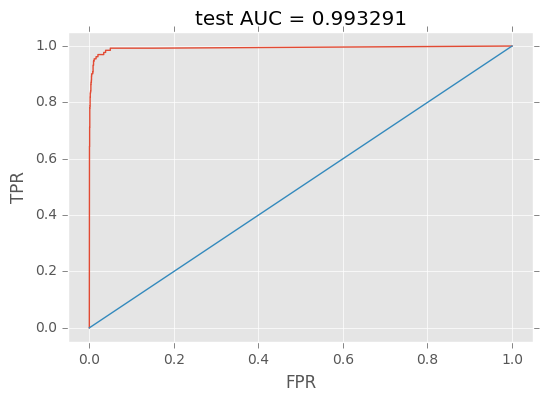

In [18]:
test_predicted_labels = [float(label) 
                         for label in open('../../output/20news_test_predictions.txt').readlines()]

auc = sklearn.metrics.roc_auc_score(test_labels, test_predicted_labels)
roc_curve = sklearn.metrics.roc_curve(test_labels, test_predicted_labels)

plt.plot(roc_curve[0], roc_curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

Полученное значения AUC говорит о высоком качестве классификации.

### Ссылки

- https://github.com/JohnLangford/vowpal_wabbit/wiki